# Test azimuth and elevation spread maps

Testing is done by:
- Consering a small and single-cell map computed by the evaluated tracer
- Placing a Sionna receiver in the center of the map

The mean directions of departure and arrival are computed by the evaluated tracer should match the one computed from the channel impulse response (CIR) computed by Sionna for the receiver located at the center of the map.

In [1]:
import os
gpu_num = 0# Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import pickle

from sionna.rt import Scene, Transmitter, PlanarArray, Receiver
from instant_rm import MapTracer

In [3]:
# Test configuration

scene_file = "../scenes/box/box.xml"

tx_position = np.array([1.0, 0.0, 4.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

cm_center = np.array([0.0, 0.0, 1.0])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([0.05, 0.05]) # Small CM with a single cell
cm_cell_size = cm_size

# Testing is done for multiple values of the maximum depth
max_depths = [0, 1, 3, 5, 7, 9, 10]

# Number of samples used to generate the reference angular spreads with
# Sionna
num_samples_ref = int(1e6)

# Number of samples used for the evaluated tracer
num_samples_eval = int(1e9)

In [4]:
# Utility to compute the ASM and ESM from a CIR
def compute_mean_direction(a, theta, phi):
    
    # Total power
    p = np.sum(a)
    a = np.expand_dims(a, axis=1)

    k = np.stack([np.sin(theta)*np.cos(phi),
                  np.sin(theta)*np.sin(phi),
                  np.cos(theta)], axis=-1)

    # Mean direction
    k_mean = np.sum(a*k,axis=0)/p
    
    return k_mean

In [5]:
# Sionna is used to generate reference angular spreads

sn_scene = Scene(scene_file)
sn_scene.frequency = fc

# Configure antenna array for all transmitters
sn_scene.tx_array = PlanarArray(num_rows=1,
                                num_cols=1,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=tx_pattern,
                                polarization="V",
                                polarization_model=2)

# Configure antenna array for all receivers
sn_scene.rx_array = PlanarArray(num_rows=1,
                                num_cols=1,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="iso",
                                polarization="VH",
                                polarization_model=2)
# Add a transmitters
tx = Transmitter(name="tx",
                 position=tx_position,
                 orientation=tx_orientation)
sn_scene.add(tx)

rx = Receiver(name=f"rx",
                 position=cm_center,
                 orientation=[0.0,0.0,0.0])
sn_scene.add(rx)

In [6]:
# Load Mitsuba scene
mi_scene = mi.load_file(scene_file)

In [7]:
# Direction of arrival and departure from the tracer
vals_ka = []
vals_kd = []
# Reference direction of arrival and departure
vals_ka_ref = []
vals_kd_ref = []
for max_depth in max_depths:

    ## Reference with Sionna
    
    # Compute CIR
    paths = sn_scene.compute_paths(max_depth=max_depth, num_samples=num_samples_ref,
                                   check_scene=False, los=True, diffraction=False, scattering=False)
    a = paths.a.numpy()[0,0,:,0,0,:,0]
    # [num_paths]
    a = np.sum(np.square(np.abs(a)), axis=0)
    # [num_paths]
    theta_r = paths.theta_r.numpy()[0,0,0,:]
    # [num_paths]
    phi_r = paths.phi_r.numpy()[0,0,0,:]
    # [num_paths]
    theta_t = paths.theta_t.numpy()[0,0,0,:]
    # [num_paths]
    phi_t = paths.phi_t.numpy()[0,0,0,:]
    
    # Reference mean direction of arrival
    ka_ref = compute_mean_direction(a, theta_r, phi_r)
    vals_ka_ref.append(ka_ref)
    #
    kd_ref = compute_mean_direction(a, theta_t, phi_t)
    vals_kd_ref.append(kd_ref)

    ## Value from the traced maps

    tracer = MapTracer(mi_scene, fc,
                       tx_pattern, tx_slant_angle,
                       cm_center, cm_orientation, cm_size, cm_cell_size,
                       num_samples_eval, max_depth)
    
    # Trace the maps
    _, _, mdam, mddm = tracer(tx_position, tx_orientation)
    #
    ka = mdam.numpy()[0,0]
    kd = mddm.numpy()[0,0]
    vals_ka.append(ka)
    vals_kd.append(kd)

vals_ka = np.stack(vals_ka, axis=0)
vals_kd = np.stack(vals_kd, axis=0)
vals_ka_ref = np.stack(vals_ka_ref, axis=0)
vals_kd_ref = np.stack(vals_kd_ref, axis=0)

# RMSE
mse_ka = np.sum(np.square(np.abs(vals_ka-vals_ka_ref)), axis=1)/np.sum(np.square(np.abs(vals_ka_ref)), axis=1)
mse_kd = np.sum(np.square(np.abs(vals_ka-vals_ka_ref)), axis=1)/np.sum(np.square(np.abs(vals_ka_ref)), axis=1)

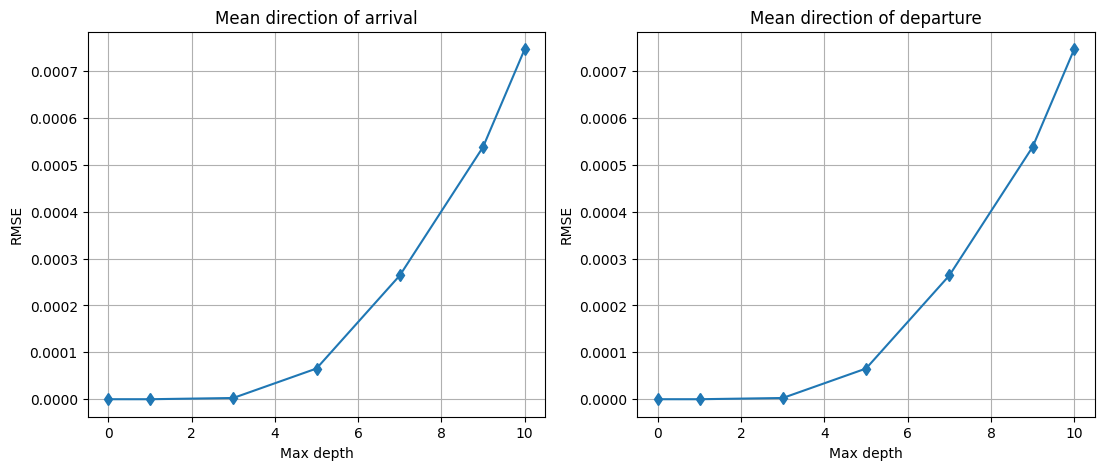

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
#
ax1.set_title("Mean direction of arrival")
ax1.plot(max_depths, mse_ka, 'd-')
ax1.set_xlabel("Max depth")
ax1.set_ylabel("RMSE")
ax1.grid(True)
#
ax2.set_title("Mean direction of departure")
ax2.plot(max_depths, mse_kd, 'd-')
ax2.set_xlabel("Max depth")
ax2.set_ylabel("RMSE")
ax2.grid(True)